# Reference
Decision Tree Classification in Python Tutorial
- https://www.datacamp.com/tutorial/decision-tree-classification-python

Finding coefficients for logistic regression in python
- https://stackoverflow.com/questions/57924484/finding-coefficients-for-logistic-regression-in-python

Interpret Logistic Regression Coefficients [For Beginners]
- https://quantifyinghealth.com/interpret-logistic-regression-coefficients/

Install Graphviz on Mac OSX
- https://macappstore.org/graphviz-2/

CART tutorial
- https://docs.google.com/presentation/d/1QT5w_79aID1gDvox-cmTaGvI0-wJ8GOYxIpX96xKKvQ/edit?usp=sharing

Logistic Regression modeling
- https://docs.google.com/presentation/d/1VbQyP86nYfsJCaowdZ8uyIDdgqz7H1n_hJEmFi916Bc/edit?usp=sharing


In [54]:
import sys
!{sys.executable} -m pip install --upgrade pyreadstat
!{sys.executable} -m pip install --upgrade sklearn
!{sys.executable} -m pip install --upgrade rpy2
!{sys.executable} -m pip install --upgrade pydotplus
!{sys.executable} -m pip install --upgrade graphviz
!{sys.executable} -m pip install --upgrade statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 627.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 594.7 kB/s eta 0:00:00a 0:00:01


In [55]:
import pandas as pd
import pyreadstat

from datascience import *
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.linear_model import LogisticRegression
# sklearn.externals.six import StringIO  
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn import tree
import statsmodels.api as sm

from IPython.display import Image
from IPython.display import display

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

import pydotplus
import graphviz

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set()

path_data = '/Users/ytchen/Documents/NCU/2022/DataScience/data/'
inline = 'w5_jsq'
mydate = '20221226'


In [3]:
# Import functions
# Note there is a lib directory under '..'
# Also a '__init__.py' under lib directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
# To compute IV (Information values) for categorical singal with weighting.
# To model bads/frauds as 1.
# Similar to FICO scores.
# The lower the score, the higher the probability of bads.
# Hence the scores sorted in ascending order.
def compute_iv_cat(target, output, rs_rate_0=1, rs_rate_1=1):
    """
    Args:
        target: Array of target, 0 or 1 for binary classification.
        output: Array of categorical signal.
        rs_rate_0: Reverse sampling rate for negative, default is 1.
        rs_rate_1: Reverse sampling rate for positive, default is 1.
    Returns:
        Sum of information values across all categories.

    Usage example:
        ivs = ComputeIVCat(target, actual, 1, 1)
    """
    import pandas as pd
    import numpy as np

    a = pd.Series(output).unique()

    n = len(a)
    tot = np.repeat(0, n)
    bads = np.repeat(0, n)
    goods = np.repeat(0, n)
    tmp = [target[i] for i, val in enumerate(target) if val==0]
    ngoods = len(tmp)*rs_rate_0
    tmp = [target[i] for i, val in enumerate(target) if val==1]
    nbads = len(tmp)*rs_rate_1
    ntot = ngoods + nbads

    for i in np.arange(0, n):
        st = [target[ix] for ix, val in enumerate(output) if val==a[i]]
        tmp = [st[i] for i, val in enumerate(st) if val==0]
        goods[i] = len(tmp)*rs_rate_0
        tmp = [st[i] for i, val in enumerate(st) if val==1]
        bads[i] = len(tmp)*rs_rate_1
        tot[i] = goods[i] + bads[i]

    idx = np.argsort(a)
    a = a[idx]
    tot = tot[idx]
    bads = bads[idx]
    goods = goods[idx]

    cumtot = np.cumsum(tot, dtype=float)
    cumbads = np.cumsum(bads, dtype=float)
    cumgoods = np.cumsum(goods, dtype=float)
    pctpop = cumtot/ntot

    prgoods = goods/ngoods
    prbads = bads/nbads
    wpattern = np.log(prgoods/prbads)
    prcumgoods = np.cumsum(prgoods)
    prcumbads = np.cumsum(prbads)
    iv = (prgoods - prbads)*wpattern

    iv = [iv[i] for i, val in enumerate(iv) if np.isfinite(val)]
    iv = [iv[i] for i, val in enumerate(iv) if not np.isnan(val)]
    y = sum(iv)

    return y


In [5]:
# Calculate IV (Information Values) for categorical signal selection.
def iv_cat_select(flag, df, rs_rate_0=1, rs_rate_1=1):
    """
    Args:
        flag: The response (target).
        df: Data frame or matrix, all categorical signals
        rs_rate_0: Reverse sampling rate for negative, default is 1.
        rs_rate_1: Reverse sampling rate for positive, default is 1.
    Returns:
        Information values for each singal in descending order
    """
    
    import pandas as pd
    import numpy as np    
    #from compute_iv_cat import compute_iv_cat

    cols = df.columns
    ncol = len(cols)
    ivs = np.repeat(0.1, ncol)

    for i, val in enumerate(cols):
        print(i)
        signal = df[val]
        iv = compute_iv_cat(flag, signal, rs_rate_0, rs_rate_1)
        print(iv)
        ivs[i] = iv

    z = pd.DataFrame({"varname": cols, "iv": ivs})
    z = z.sort_values(by='iv', ascending=False)
    return z


In [32]:
# Make sure 'Heiti TC' is present so as to display Chinese characters properly in plots.
print([f for f in matplotlib.font_manager.fontManager.ttflist if 'Heiti' in f.name])
matplotlib.rcParams['font.family'] = ['Heiti TC']


[FontEntry(fname='/System/Library/Fonts/STHeiti Light.ttc', name='Heiti TC', style='normal', variant='normal', weight=300, stretch='normal', size='scalable'), FontEntry(fname='/System/Library/Fonts/STHeiti Medium.ttc', name='Heiti TC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')]


In [7]:
df = pd.read_spss('/Users/ytchen/Documents/NCU/2022/DataScience/D00165/data/w5_jsq.sav')
print(df.shape)
df.to_csv(path_data + 'w5_jsq.csv', index=False)
df


(1618, 400)


,w5_id,w5_gender,w5st_time,w5st_time_month,w5st_time_day,w5st_time_hour,w5st_time_minute,w5a1_1,w5a1_2,w5a1_3,...,w5d40_2,w5d40_3,w5d40_4,w5d40_5,w5d40_6,w5ed_time,w5ed_time_month,w5ed_time_day,w5ed_time_hour,w5ed_time_minute
0,10007.0,女,2017/8/28 09:01,8.0,28.0,9.0,1.0,沒有,沒有,有,...,普通,多半如此,多半如此,普通,多半如此,2017/8/28 09:33,8.0,28.0,9.0,33.0
1,10011.0,女,2017/7/25 14:30,7.0,25.0,14.0,30.0,有,沒有,有,...,多半如此,普通,普通,普通,普通,2017/7/25 14:52,7.0,25.0,14.0,52.0
2,10013.0,女,2017/8/25 13:33,8.0,25.0,13.0,33.0,有,沒有,有,...,普通,普通,普通,普通,普通,2017/8/25 13:58,8.0,25.0,13.0,58.0
3,10015.0,男,2017/7/28 13:36,7.0,28.0,13.0,36.0,有,沒有,有,...,幾乎時常如此,幾乎時常如此,幾乎時常如此,多半如此,普通,2017/7/28 13:47,7.0,28.0,13.0,47.0
4,10018.0,女,2017/7/31 12:21,7.0,31.0,12.0,21.0,有,沒有,沒有,...,普通,普通,普通,普通,普通,2017/7/31 12:37,7.0,31.0,12.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,33361.0,女,2017/7/17 17:12,7.0,17.0,17.0,12.0,有,沒有,有,...,NaN,NaN,NaN,NaN,NaN,2017/7/17 17:30,7.0,17.0,17.0,30.0
1614,33364.0,男,2017/7/11 18:14,7.0,11.0,18.0,14.0,有,有,有,...,普通,普通,普通,普通,普通,2017/7/11 18:26,7.0,11.0,18.0,26.0
1615,33366.0,男,2017/7/11 17:36,7.0,11.0,17.0,36.0,沒有,沒有,有,...,NaN,NaN,NaN,NaN,NaN,2017/7/11 17:46,7.0,11.0,17.0,46.0
1616,33368.0,男,2017/7/31 23:37,7.0,31.0,23.0,37.0,有,沒有,有,...,普通,多半如此,普通,很少如此,普通,2017/7/31 23:54,7.0,31.0,23.0,54.0


In [8]:
# Drop duplicate rows.
df = df.drop_duplicates()
print(df.shape)

# Make sure no duplicate IDs.
df.w5_id.value_counts()


(1618, 400)


10007.0    1
30793.0    1
30814.0    1
30811.0    1
30809.0    1
          ..
20351.0    1
20347.0    1
20344.0    1
20343.0    1
33384.0    1
Name: w5_id, Length: 1618, dtype: int64

In [9]:
# Keep test signals - family life.
# 'w5b1_1' - 'w5b1_4':  number of brothers and sisters.
cols_test = ['w5_id', 'w5_gender', 'w5c12', 'w5c13', 'w5b1_1',
            'w5b1_2', 'w5b1_3', 'w5b1_4', 'w5b2', 'w5b3',
            'w5b4', 'w5b5', 'w5b6', 'w5b7', 'w5b8',
            'w5b9', 'w5b10', 'w5b11', 'w5b12', 'w5b12_k',
            'w5b13', 'w5b14_1', 'w5b14_2', 'w5b14_3', 'w5b14_4',
            'w5b14_5', 'w5b14_6', 'w5b14_7', 'w5b14_8', 'w5b14_9',
            'w5b14_10', 'w5b14_11', 'w5b14_12', 'w5b14_13', 'w5b14_14', 
            'w5b14_15', 'w5b15_1', 'w5b15_2', 'w5b15_3',]
df_tb = Table().from_df(df)
df_stb = df_tb.select(cols_test)
df_stb.show(6)


w5_id,w5_gender,w5c12,w5c13,w5b1_1,w5b1_2,w5b1_3,w5b1_4,w5b2,w5b3,w5b4,w5b5,w5b6,w5b7,w5b8,w5b9,w5b10,w5b11,w5b12,w5b12_k,w5b13,w5b14_1,w5b14_2,w5b14_3,w5b14_4,w5b14_5,w5b14_6,w5b14_7,w5b14_8,w5b14_9,w5b14_10,w5b14_11,w5b14_12,w5b14_13,w5b14_14,w5b14_15,w5b15_1,w5b15_2,w5b15_3
10007,女,有,從來沒有,0,0,0,0,很少交談,大部分知道,少部分認識,大部分關心,很少參加,很常吵架,很少,有，一至二次,每週一天,洗碗換被子拖地洗浴室擦流理檯,爸爸,nan,稍微有些限制,不同意,不同意,同意,不同意,同意,非常不同意,同意,非常不同意,非常不同意,同意,同意,不同意,非常不同意,同意,同意,非常不同意,非常不同意,不同意
10011,女,沒有,偶爾_續答C13_1,1,2,0,0,大部分時間會,每次都知道,大部分認識,大部分關心,很少參加,很常吵架,很少,從來沒有,不做家事_跳答B12,nan,媽媽,nan,稍微有些限制,同意,同意,不同意,不同意,同意,不同意,同意,同意,同意,非常同意,同意,不同意,不同意,同意,非常同意,不同意,不同意,不同意
10013,女,沒有,從來沒有,1,0,0,1,每天都會,每次都知道,大部分認識,大部分關心,很少參加,很少吵架,時常,從來沒有,每週二到三天,洗碗 摺衣服,媽媽,nan,稍微有些幫助,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意
10015,男,沒有,從來沒有,0,2,0,0,每天都會,每次都知道,大部分認識,每次都關心,大部分會參加,很少吵架,時常,從來沒有,每週二到三天,打掃,媽媽,nan,稍微有些幫助,非常同意,非常同意,同意,非常同意,同意,非常同意,同意,同意,同意,非常同意,非常同意,同意,同意,同意,同意,同意,同意,非常同意
10018,女,沒有,從來沒有,2,0,0,0,很少交談,大部分知道,少部分認識,大部分關心,大部分會參加,很常吵架,很少,從來沒有,每週二到三天,洗碗,自己賺的,nan,稍微有些限制,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意,同意
10021,男,沒有,從來沒有,1,1,0,0,大部分時間會,每次都知道,少部分認識,大部分關心,大部分會參加,很少吵架,很少,從來沒有,每週四到五天,擦地,媽媽,nan,有很大的幫助,同意,非常同意,同意,非常同意,同意,同意,同意,非常同意,同意,非常同意,非常同意,非常同意,同意,同意,非常同意,不同意,同意,非常同意


In [10]:
"""
Ignore 'w5b12_k' since most nan.
"""
print(df_stb.group('w5b12'))
print(df_stb.group('w5b12_k'))
df_stb = df_stb.drop('w5b12_k')


w5b12    | count
其他       | 50
哥哥或姊姊    | 14
媽媽       | 599
爸爸       | 121
祖父母或其他親戚 | 112
自己賺的     | 722
w5b12_k | count
nan     | 1568
一半一半    | 1
丈夫      | 1
低收的輔助金  | 1
低收補助    | 1
先生      | 4
助學貸款    | 1
哥哥 媽媽   | 1
固定獎學金   | 1
孩子的爸    | 1
... (24 rows omitted)


In [11]:
# Create our response as high risk of drug usage.
# Either their friends are using it or the drug is easily seen in their daily life.
print(df_stb.group('w5c12'))
print(df_stb.group('w5c13'))
df_stb.pivot('w5c13', 'w5c12')


w5c12 | count
有     | 51
沒有    | 1567
w5c13      | count
nan        | 1
偶爾_續答C13_1 | 157
從來沒有       | 1398
有時_續答C13_1 | 41
經常_續答C13_1 | 21


w5c12,nan,偶爾_續答C13_1,從來沒有,有時_續答C13_1,經常_續答C13_1
有,0,18,22,5,6
沒有,1,139,1376,36,15


In [12]:
sdf = df_stb.to_df()
def get_risk(x, y):
    if x == '有':
        return 1
    elif y == '經常_續答C13_1':
        return 1
    else:
        return 0
    
sdf = sdf.assign(drug_risk = [get_risk(x, y) for x, y in zip(sdf.w5c12, sdf.w5c13)])
print(sdf.shape)
sdf_tb = Table().from_df(sdf)
print(sdf_tb.group('drug_risk'))
sdf_tb.column('drug_risk').mean()


(1618, 39)
drug_risk | count
0         | 1552
1         | 66


0.040791100123609397

w5b2   | count
大部分時間會 | 722
很少交談   | 320
從來不會   | 13
每天都會   | 563


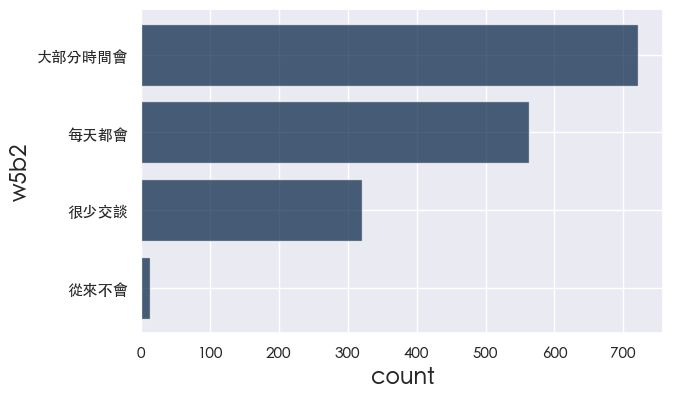

In [13]:
# Bar chart
# 你平時會不會和家人交談？
print(sdf_tb.group('w5b2'))
sdf_tb.group('w5b2').sort('count', descending=True).barh('w5b2')


In [14]:
# Pivot.
# There is no clear association between drug_risk and family_conversation.
sdf_tb.pivot('w5b2', 'drug_risk')


drug_risk,大部分時間會,很少交談,從來不會,每天都會
0,699,297,12,544
1,23,23,1,19


In [15]:
# 過去一年，你有沒有離家出走過？
runaway = sdf_tb.select('w5b2', 'w5b9').relabel('w5b2', 'family_conversation').relabel('w5b9', 'run_away_home')
runaway_grp = runaway.group(['family_conversation', 'run_away_home'])
runaway_grp


family_conversation,run_away_home,count
大部分時間會,從來沒有,700
大部分時間會,有，一至二次,22
很少交談,從來沒有,299
很少交談,有，一至二次,15
很少交談,有，三至四次,4
很少交談,有，五次(含)以上,2
從來不會,從來沒有,11
從來不會,有，一至二次,1
從來不會,有，五次(含)以上,1
每天都會,從來沒有,553


In [16]:
# Pivot, again.
# A bit inconsistent.
runaway_pv = runaway.pivot('run_away_home', 'family_conversation')
runaway_pv


family_conversation,從來沒有,有，一至二次,有，三至四次,有，五次(含)以上
大部分時間會,700,22,0,0
很少交談,299,15,4,2
從來不會,11,1,0,1
每天都會,553,8,0,2


<AxesSubplot: xlabel='run_away_home', ylabel='count'>

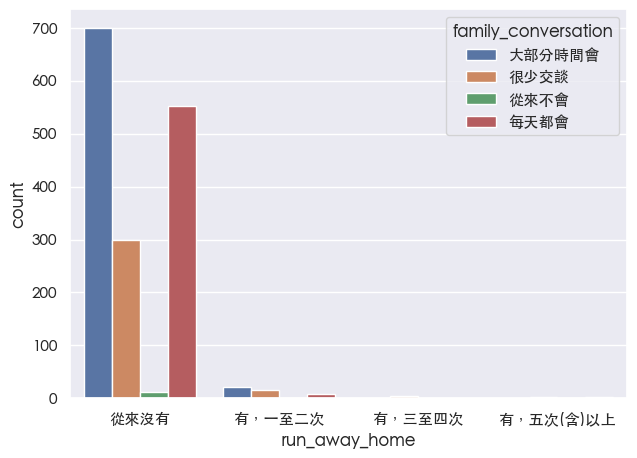

In [17]:
# 2-D bar chart.
runaway_grp_df = runaway_grp.to_df()
sns.barplot(x='run_away_home', y='count', hue='family_conversation', data=runaway_grp_df)


# How about run_away_home vs. drug_risk?
- 動手做


In [18]:
# Get signal names.

# Get factor signals
var_names = sdf.columns
#print(var_names)
var_names_sub = list(set(var_names).difference(set(['drug_risk', 'w5_id', 'w5c12', 'w5c13'])))
#print(var_names_sub)
print(len(var_names_sub))

# 'w5b1_1' - 'w5b1_4':  number of brothers and sisters.
num_names = ['w5b1_1', 'w5b1_2', 'w5b1_3', 'w5b1_4']
fac_names = list(set(var_names_sub).difference(set(num_names)))
print(fac_names)
print(len(fac_names))


35
['w5b14_3', 'w5b4', 'w5b8', 'w5b14_9', 'w5b13', 'w5b14_14', 'w5b11', 'w5b5', 'w5_gender', 'w5b9', 'w5b3', 'w5b12', 'w5b7', 'w5b2', 'w5b6', 'w5b15_1', 'w5b14_5', 'w5b15_2', 'w5b14_15', 'w5b15_3', 'w5b14_12', 'w5b14_7', 'w5b14_6', 'w5b14_10', 'w5b14_2', 'w5b14_1', 'w5b14_4', 'w5b14_11', 'w5b10', 'w5b14_8', 'w5b14_13']
31


# Information Value

In [19]:
# IV for categorical signals.
civs = iv_cat_select(sdf.drug_risk, sdf[fac_names], 1, 1)
print(civs)

# Backup
civs.to_csv(path_data + 'civs_' + inline + '_' + mydate + '.csv', index=False)


0
0.118810497949
1
0.0535257634216
2
0.0765983023207
3
0.172012247839
4
0.14347532484
5
0.102173097727
6
0.386559392956
7
0.0353007126387
8
0.00987846520931
9
0.207055757404
10
0.0774389838001
11
0.130479398724
12
0.215206544857
13
0.137639541496
14
0.0255711944702
15
0.143209606065
16
0.112133563416
17
0.114426311788
18
0.049052971207
19
0.0780931480986
20
0.0640526866097
21
0.0528687186009
22
0.106459802859
23
0.0666181359568
24
0.0859245003741
25
0.0478981424179
26
0.238922690506
27
0.129862492569
28
0.187221649663
29
0.138801778761
30
0.245308177968
      varname        iv
6       w5b11  0.386559
30   w5b14_13  0.245308
26    w5b14_4  0.238923
12       w5b7  0.215207
9        w5b9  0.207056
28      w5b10  0.187222
3     w5b14_9  0.172012
4       w5b13  0.143475
15    w5b15_1  0.143210
29    w5b14_8  0.138802
13       w5b2  0.137640
11      w5b12  0.130479
27   w5b14_11  0.129862
0     w5b14_3  0.118810
17    w5b15_2  0.114426
16    w5b14_5  0.112134
22    w5b14_6  0.106460
5    w5b

/var/folders/7t/drc_5mxn3c96k2_3zc1n57yh0000gn/T/ipykernel_67057/2345831196.py:55: RuntimeWarning: divide by zero encountered in divide
  wpattern = np.log(prgoods/prbads)
/var/folders/7t/drc_5mxn3c96k2_3zc1n57yh0000gn/T/ipykernel_67057/2345831196.py:55: RuntimeWarning: divide by zero encountered in log
  wpattern = np.log(prgoods/prbads)


In [20]:
# Extracted categorical signals whose iv >= 0.01
civs_final = civs[civs.iv > 0.01]
#print(len(civs_final))
#print(civs_final)

# Categorical signals identified so far
iv_fac_names = civs_final.varname
print(iv_fac_names)
print(len(iv_fac_names))

# Eyeball # of categories again
print([sdf[x].nunique() for x in iv_fac_names])


6        w5b11
30    w5b14_13
26     w5b14_4
12        w5b7
9         w5b9
28       w5b10
3      w5b14_9
4        w5b13
15     w5b15_1
29     w5b14_8
13        w5b2
11       w5b12
27    w5b14_11
0      w5b14_3
17     w5b15_2
16     w5b14_5
22     w5b14_6
5     w5b14_14
24     w5b14_2
19     w5b15_3
10        w5b3
2         w5b8
23    w5b14_10
20    w5b14_12
1         w5b4
21     w5b14_7
18    w5b14_15
25     w5b14_1
7         w5b5
14        w5b6
Name: varname, dtype: object
30
[800, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [21]:
# What is 'w5b11'
# The highest in IV = 0.39
# 通常你會做些什麼家事？(請寫出常做的家事內容)
# Too many categories, drop the variable.
print(sdf_tb.group('w5b11').show(15))
#sdf_tb.group('w5b2').sort('count', descending=True).barh('w5b2')

iv_fac_names2 = list(set(iv_fac_names).difference(set(['w5b11'])))
print(len(iv_fac_names2))


w5b11,count
5,1
Cleaning,1
Cleaning the room,1
Wash dishes,1
nan,228
、洗衣服,1
。洗碗,1
不一定,1
不清楚,1
丟垃圾,2


None
29


In [22]:
# What is 'w5b14_13'
# 2nd highest in IV = 0.25
# 家人能敏銳察覺我的想法與感受
print(sdf_tb.group('w5b14_13'))

# Pivot.
# There is no clear association between drug_risk and family_conversation.
sdf_tb.pivot('w5b14_13', 'drug_risk')


w5b14_13 | count
不同意      | 393
同意       | 934
非常不同意    | 72
非常同意     | 219


drug_risk,不同意,同意,非常不同意,非常同意
0,379,902,60,211
1,14,32,12,8


# Decision tree
- Decision Tree Classification in Python Tutorial
- https://www.datacamp.com/tutorial/decision-tree-classification-python

In [23]:
# One-hot-encoding
one_hot_fac = pd.get_dummies(sdf[iv_fac_names2])
one_hot_fac


,w5b14_3_不同意,w5b14_3_同意,w5b14_3_非常不同意,w5b14_3_非常同意,w5b15_3_不同意,w5b15_3_同意,w5b15_3_非常不同意,w5b15_3_非常同意,w5b4_全部都認識,w5b4_大部分認識,...,w5b14_5_非常不同意,w5b14_5_非常同意,w5b15_2_不同意,w5b15_2_同意,w5b15_2_非常不同意,w5b15_2_非常同意,w5b14_15_不同意,w5b14_15_同意,w5b14_15_非常不同意,w5b14_15_非常同意
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1614,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1615,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1616,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [24]:
# Features
X = pd.concat([one_hot_fac, sdf[num_names]], axis=1)
# Target variable
y = sdf.drug_risk 

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X, y)

# In-sample predict
y_pred = clf.predict(X)

# Evaluate model
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y, y_pred))


Accuracy: 0.96044499382


'\n'

In [35]:
print(y.mean())
print(X.shape)
X.columns


0.0407911001236
(1618, 124)


Index(['w5b14_3_不同意', 'w5b14_3_同意', 'w5b14_3_非常不同意', 'w5b14_3_非常同意',
       'w5b15_3_不同意', 'w5b15_3_同意', 'w5b15_3_非常不同意', 'w5b15_3_非常同意',
       'w5b4_全部都認識', 'w5b4_大部分認識',
       ...
       'w5b15_2_非常不同意', 'w5b15_2_非常同意', 'w5b14_15_不同意', 'w5b14_15_同意',
       'w5b14_15_非常不同意', 'w5b14_15_非常同意', 'w5b1_1', 'w5b1_2', 'w5b1_3',
       'w5b1_4'],
      dtype='object', length=124)

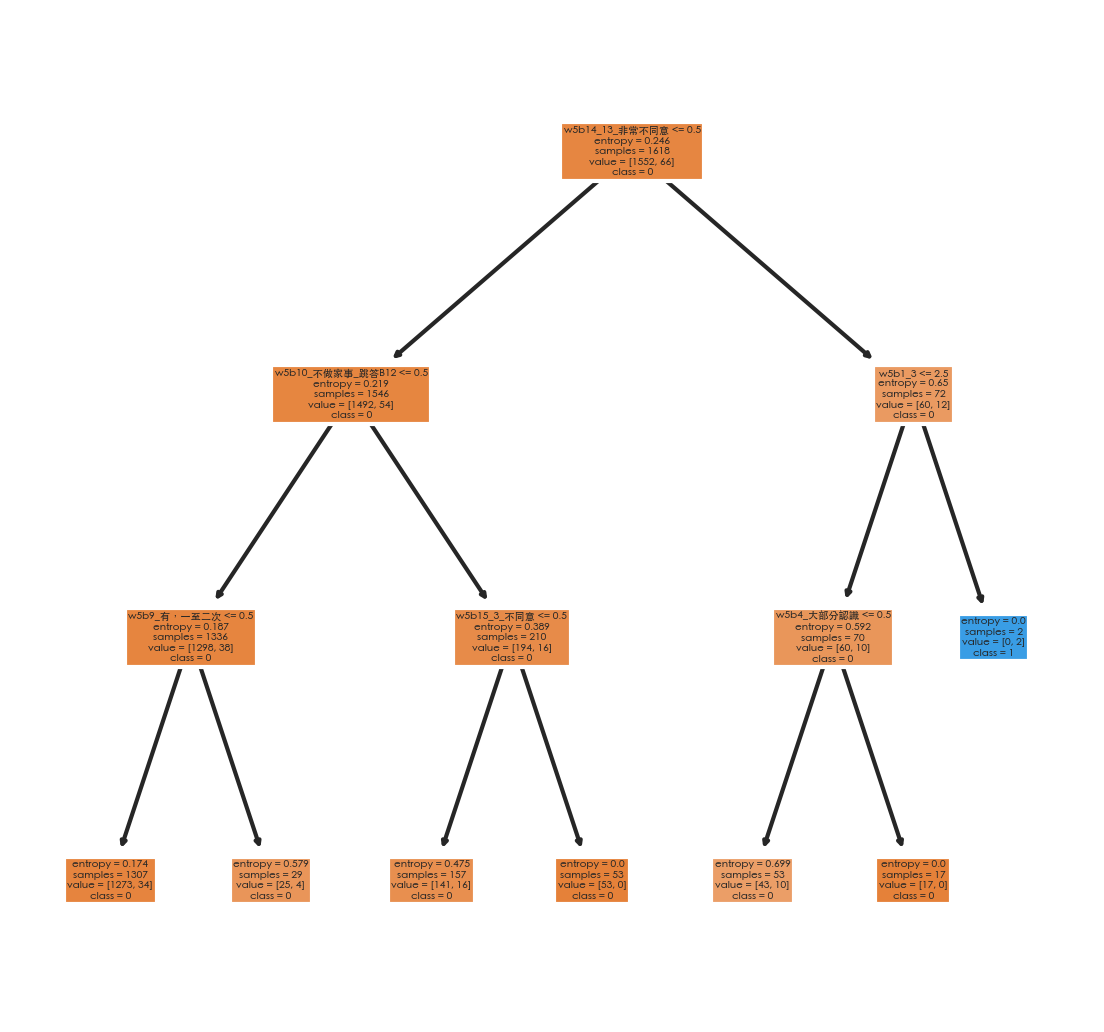

In [34]:
# Visualize the tree

# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

tree.plot_tree(clf,
           feature_names=feature_names, 
           class_names=['0','1'],
           filled = True);

# You can save your plot if you want
fig.savefig(path_data + 'w5_jsq_tree1.png')


In [36]:
"""
feature_names = X.columns
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names,
                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(path_data + 'w5_jsq_tree1.png')
Image(graph.create_png())
"""


"\nfeature_names = X.columns\ndot_data = StringIO()\nexport_graphviz(clf, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True, feature_names=feature_names,\n                class_names=['0','1'])\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_png(path_data + 'w5_jsq_tree1.png')\nImage(graph.create_png())\n"

# Logistic regression

In [45]:
# DataFrame
ssdf = pd.concat([sdf[['drug_risk']], one_hot_fac, sdf[num_names]], axis=1)
ssdf = ssdf.rename(columns={'drug_risk': 'flag'})
print(ssdf.shape)

# rpy2
# Allow conversion
pandas2ri.activate()

# Convert to R dataframe
r_ssdf = ro.conversion.py2rpy(ssdf) # trn_next is a pd.DataFrame object

## Convert back to pandas DataFrame        
#pd_dt = ro.conversion.rpy2py(r_dt)
"""
"""

(1618, 125)


'\n'

In [46]:
# Import packages
base, stats = importr('base'), importr('stats')

# Import Functions
glm = stats.glm
#hpc, rsmax2, tabu = bnlearn.hpc, bnlearn.rsmax2, bnlearn.tabu


In [48]:
rstring="""
    function(raw){
        # Forward stepwise regression
        null.raw <- glm(flag~1, family=binomial, data=raw)
        print(summary(null.raw))
        
        full.raw <- glm(flag~., family=binomial, data=raw)
        print(summary(full.raw))
        
        # At most 20 vars selected
        step.raw <- step(null.raw, scope=list(lower=null.raw, upper=full.raw), direction="forward", steps=10)
        desp <- summary(step.raw)
        print(desp)
        
        coeff <- as.data.frame(desp$coefficients)
        names(coeff) <- c("Estimate", "StdError", "z_value", "pr_gt_abs_z")
        coeff
    }
"""
rfunc = ro.r(rstring)
r_coeff = rfunc(r_ssdf)

# Convert back to pandas DataFrame
coeff_df = ro.conversion.rpy2py(r_coeff)
print(coeff_df)




Call:
glm(formula = flag ~ 1, family = binomial, data = raw)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2886  -0.2886  -0.2886  -0.2886   2.5295  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.1576     0.1257  -25.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 551.58  on 1617  degrees of freedom
Residual deviance: 551.58  on 1617  degrees of freedom
AIC: 553.58

Number of Fisher Scoring iterations: 6


Call:
glm(formula = flag ~ ., family = binomial, data = raw)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3506  -0.2649  -0.1529  -0.0843   3.3022  

Coefficients: (29 not defined because of singularities)
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.258e+00  1.824e+00  -0.690 0.490393    
w5b14_3_不同意            3.236e-01  9.147e-01  

w5b15_2_同意             -1.709e-01  7.965e-01  -0.215 0.830129    
w5b15_2_非常不同意       -1.736e+00  1.182e+00  -1.469 0.141859    
w5b15_2_非常同意                 NA         NA      NA       NA    
w5b14_15_不同意          -3.189e-01  9.317e-01  -0.342 0.732131    
w5b14_15_同意            -2.692e-01  4.757e-01  -0.566 0.571398    
w5b14_15_非常不同意      -8.249e-01  1.315e+00  -0.627 0.530502    
w5b14_15_非常同意                NA         NA      NA       NA    
w5b1_1                    3.598e-01  1.984e-01   1.813 0.069778 .  
w5b1_2                    1.200e-01  1.388e-01   0.864 0.387342    
w5b1_3                   -1.731e-01  2.343e-01  -0.739 0.459951    
w5b1_4                    1.662e-01  1.646e-01   1.010 0.312650    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 551.58  on 1617  degrees of freedom
Residual deviance: 408.47  on 1522  degrees of freedom
AIC: 600.47

Number of Fisher Scoring ite

+ w5b15_2_非常不同意        1   532.37 538.37
+ w5b14_2_非常不同意        1   532.37 538.37
+ w5b14_9_非常不同意        1   532.38 538.38
+ w5b4_完全不認識           1   532.38 538.38
+ w5b13_稍微有些限制        1   532.42 538.42
+ w5b3_大部分知道           1   532.44 538.44
+ w5b14_2_同意              1   532.47 538.47
+ w5b14_10_非常同意         1   532.50 538.50
+ w5b14_3_非常不同意        1   532.56 538.56
+ w5b14_9_同意              1   532.56 538.56
+ w5b14_3_非常同意          1   532.64 538.64
+ w5b3_從來不知道           1   532.65 538.65
+ w5b14_10_同意             1   532.72 538.72
+ w5b15_3_非常不同意        1   532.72 538.72
+ w5b14_6_非常不同意        1   532.73 538.73
+ w5b14_7_非常同意          1   532.75 538.75
+ w5b14_12_非常不同意       1   532.82 538.82
+ w5b14_6_非常同意          1   532.84 538.84
+ w5b10_每週一天            1   532.84 538.84
+ w5b14_1_不同意            1   532.85 538.85
+ w5b14_4_同意              1   532.86 538.86
+ w5b14_8_同意              1   532.89 538.89
+ w5b4_全部都認識           1   532.94 538.94
+ w5b2_每天都會             1   532.95 5

+ w5b5_大部分關心           1   523.11 531.11
+ w5b12_祖父母或其他親戚    1   523.11 531.11
+ w5b14_9_不同意            1   523.11 531.11
+ w5b13_完全沒有影響        1   523.11 531.11
+ w5b14_15_同意             1   523.11 531.11
+ w5b6_大部分會參加         1   523.11 531.11
+ w5b5_很少關心             1   523.11 531.11
+ w5b14_12_不同意           1   523.11 531.11
+ w5b14_1_非常同意          1   523.11 531.11
+ w5b14_5_不同意            1   523.11 531.11
+ w5b4_大部分認識           1   523.11 531.11
+ w5b10_每週一天            1   523.11 531.11
+ w5b14_7_非常不同意        1   523.11 531.11
+ w5b14_7_不同意            1   523.11 531.11
+ w5b14_13_同意             1   523.11 531.11

Step:  AIC=524.57
flag ~ w5b14_13_非常不同意 + w5b10_不做家事_跳答B12 + 
    w5b7_幾乎天天吵

                           Df Deviance    AIC
+ w5b12_媽媽                1   510.28 520.28
+ w5b15_3_同意              1   511.08 521.08
+ w5b15_3_不同意            1   511.71 521.71
+ w5b9_從來沒有             1   511.73 521.73
+ w5b13_稍微有些幫助        1   512.90 522.90
+ `w5b9_有，一至二次`       1   513.25 52

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                           Df Deviance    AIC
+ w5b14_4_非常不同意        1   486.62 504.62
+ w5b15_1_同意              1   488.60 506.60
+ w5b14_14_非常同意         1   489.16 507.16
+ w5b15_1_非常同意          1   489.24 507.24
+ w5b13_稍微有些幫助        1   490.32 508.32
+ w5b14_3_非常不同意        1   490.68 508.68
+ w5b15_2_非常同意          1   490.92 508.92
+ w5b14_11_同意             1   491.11 509.11
+ w5b1_1                    1   491.14 509.14
+ w5b2_很少交談             1   491.46 509.46
+ w5b15_1_非常不同意        1   491.79 509.79
+ w5b14_14_同意             1   491.82 509.82
<none>                          493.99 509.99
+ w5b14_2_同意              1   491.99 509.99
+ w5b2_大部分時間會         1   492.05 510.05
+ w5b6_從不參加             1   492.10 510.10
+ w5b15_2_不同意            1   492.12 510.12
+ w5b13_有很大的幫助        1   492.21 510.21
+ w5b15_3_非常同意          1   492.25 510.25
+ w5b14_2_非常同意          1   492.28 510.28
+ w5b8_從來沒有             1   492.33 510.33
+ w5b14_9_同意              1   492.45 510.45
+ w5b14_9_非常同意      

+ w5b14_5_非常同意          1   486.47 506.47
+ `w5b9_有，一至二次`       1   486.47 506.47
+ w5b14_12_不同意           1   486.48 506.48
+ w5b4_大部分認識           1   486.50 506.50
+ w5b14_1_非常不同意        1   486.50 506.50
+ w5b10_每週四到五天        1   486.51 506.51
+ w5b14_11_非常不同意       1   486.52 506.52
+ w5b12_爸爸                1   486.52 506.52
+ w5b14_5_同意              1   486.52 506.52
+ w5b14_6_不同意            1   486.52 506.52
+ w5b14_7_不同意            1   486.52 506.52
+ w5b14_1_不同意            1   486.55 506.55
+ w5b13_稍微有些限制        1   486.55 506.55
+ w5b14_10_非常同意         1   486.55 506.55
+ w5b14_5_不同意            1   486.55 506.55
+ w5b15_1_不同意            1   486.55 506.55
+ w5b4_少部分認識           1   486.55 506.55
+ w5b2_每天都會             1   486.56 506.56
+ w5b14_13_不同意           1   486.56 506.56
+ w5b14_13_同意             1   486.57 506.57
+ w5b5_從來不關心           1   486.57 506.57
+ w5b2_從來不會             1   486.58 506.58
+ w5b13_完全沒有影響        1   486.59 506.59
+ w5b7_從沒吵架過           1   486.59 

w5b14_4_非常不同意       2.0402     0.6715   3.038 0.002381 ** 
w5b14_14_非常同意        1.5545     0.4617   3.367 0.000761 ***
w5b14_4_非常同意        -1.0563     0.4932  -2.142 0.032221 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 551.58  on 1617  degrees of freedom
Residual deviance: 475.74  on 1607  degrees of freedom
AIC: 497.74

Number of Fisher Scoring iterations: 7

                  Estimate  StdError   z_value   pr_gt_abs_z
(Intercept)      -2.782472  0.520934 -5.341315  9.227499e-08
w5b14_13_非常不同意    1.463671  0.478475  3.059034  2.220519e-03
w5b10_不做家事_跳答B12  0.970085  0.303107  3.200468  1.372046e-03
w5b7_幾乎天天吵        2.079314  0.753749  2.758630  5.804427e-03
w5b12_媽媽         -0.772223  0.318803 -2.422254  1.542457e-02
w5b15_3_同意        0.976651  0.328423  2.973759  2.941759e-03
w5b9_從來沒有        -1.352961  0.467760 -2.892425  3.822800e-03
w5b14_2_非常不同意    -3.380241  1.166368 -2.8980

# 1st iteration - all coefficients are significant
- w5b14_13_非常不同意 - 家人能敏銳察覺我的想法與感受 (+ not_sensitive implies higher_drug_risk)
- w5b10_不做家事_跳答B12 - 通常一個星期裡，你有幾天會做家事？ (+ no_chore implies higher_drug_risk)
- w5b7_幾乎天天吵 - 你會不會跟父母或家中的長輩吵架？ (+ daily_fighting implies higher_drug_risk)
- w5b12_媽媽 - 主要提供你生活費來源的人是： (- mom_as_earner implies lower_drug_risk ???)
- w5b15_3_同意 - 我家與鄰居會相互往來 (+ neighbor_interaction implies higher_drug_risk ???)
- w5b9_從來沒有 - 過去一年，你有沒有離家出走過？ (- never_run_away implies lower_drug_risk)
- w5b14_2_非常不同意 - 家人彼此間覺得親近 (- not_close implies lower_drug_risk ???)
- w5b14_4_非常不同意 - 家人喜歡共度休閒時光 (+ not_enjoy_together imples higher_drug_risk)
- w5b14_14_非常同意 - 家人知道我同儕家裡的狀況 (+ know_my_friends imples higher_risk_risk ???)
- w5b14_4_非常同意 -  (redundant, removed)

In [52]:
# Get sign-make-sense coefficients
vars_tmp = coeff_df.index[1:].tolist()
print(vars_tmp)

vars_model = [vars_tmp[i] for i in [0, 1, 2, 5, 7]]
vars_model


['w5b14_13_非常不同意', 'w5b10_不做家事_跳答B12', 'w5b7_幾乎天天吵', 'w5b12_媽媽', 'w5b15_3_同意', 'w5b9_從來沒有', 'w5b14_2_非常不同意', 'w5b14_4_非常不同意', 'w5b14_14_非常同意', 'w5b14_4_非常同意']


['w5b14_13_非常不同意',
 'w5b10_不做家事_跳答B12',
 'w5b7_幾乎天天吵',
 'w5b9_從來沒有',
 'w5b14_4_非常不同意']

In [58]:
# Features
X1 = ssdf[vars_model]
# Target variable
y1 = ssdf.flag 

logit_model = sm.Logit(y1, X1)
result = logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.172602
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   flag   No. Observations:                 1618
Model:                          Logit   Df Residuals:                     1613
Method:                           MLE   Df Model:                            4
Date:                Fri, 28 Oct 2022   Pseudo R-squ.:                -0.01263
Time:                        12:35:40   Log-Likelihood:                -279.27
converged:                       True   LL-Null:                       -275.79
Covariance Type:            nonrobust   LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
w5b14_13_非常不同意       0.1407      0.517      0.272      0.785      -0.872       1.154
w5b10_不做家事_

# 2nd iteration - remaining significant
- w5b7_幾乎天天吵 - 你會不會跟父母或家中的長輩吵架？ (+ daily_fighting implies higher_drug_risk)
- w5b9_從來沒有 - 過去一年，你有沒有離家出走過？ (- never_run_away implies lower_drug_risk)
- w5b14_4_非常不同意 - 家人喜歡共度休閒時光 (+ not_enjoy_together imples higher_drug_risk)


In [61]:
# log odds ratio to odds ratio
print(np.exp(1.4686))
print(np.exp(-3.3681))
print(np.exp(0.3452))


4.34315047213
0.0344550397671
1.41227234589


# Interpretation
For binary variable with positive coefficient:
- 跟父母幾乎天天吵的人 has a 4.34 times the odds of 不天天吵的人 of taking drugs.
- 跟父母幾乎天天吵的人 has 334% (4.34 – 1 = 3.34) more odds of taking drugs than 不天天吵的人.
- 跟父母幾乎天天吵的人 multiplies by 4.34 the probability of taking drugs compared to 不天天吵的人.
- There is a 334% greater relative risk of taking drugs for 跟父母幾乎天天吵的人 compared to 不天天吵的人.

- 家人非常不喜歡共度休閒時光的人 has 41% (1.41 – 1 = .41) more odds of taking drugs than 家人不是非常不喜歡的人.

For binary variable with negative coefficient:
- 過去一年從來沒有離家出走的人 is associated with a 97% (1 – 0.03 = 0.97) reduction in the relative risk of taking drugs.

# What's next?
Prediction
- We will cover it in the future.  However it's not the main theme of social science.  I believe social study is more focus on explanation.

Causality
- DAG (Direct-Acyclic Graph) to model relationships between variables.
- Start-of-art research topics.

# What we didn't cover in the analysis
- Variable recoding procedure such as naming meaningful variable names.
- Variable rebinning such as regroup numeric or categorical variables in meaningful ways.
- Model evaluation, Gains chart, variable transformation and cross-validation.